In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Image folder path
image_folder = '/content/drive/My Drive/Image Analysis/imageset2/'

# Image file names
image_files = ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg','9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg','17.jpg', '18.jpg', '19.jpg','20.jpg']

In [4]:
# Load the VGG16 model pre-trained on ImageNet without the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Image preprocessing and CNN feature extraction function
def extract_cnn_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize all images to 224x224
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = base_model.predict(img_data)
    return features.flatten()  # Flatten the feature map


58889256/58889256 [==============================] - 0s 0us/step


In [5]:
# Extract CNN features from all images
cnn_features = []
for file in image_files:
    features = extract_cnn_features(os.path.join(image_folder, file))
    cnn_features.append(features)

# Convert list to numpy array
cnn_features = np.array(cnn_features)

1/1 [==============================] - 1s 543ms/step


In [6]:
# Standardize the features
scaler = StandardScaler()
cnn_features_scaled = scaler.fit_transform(cnn_features)

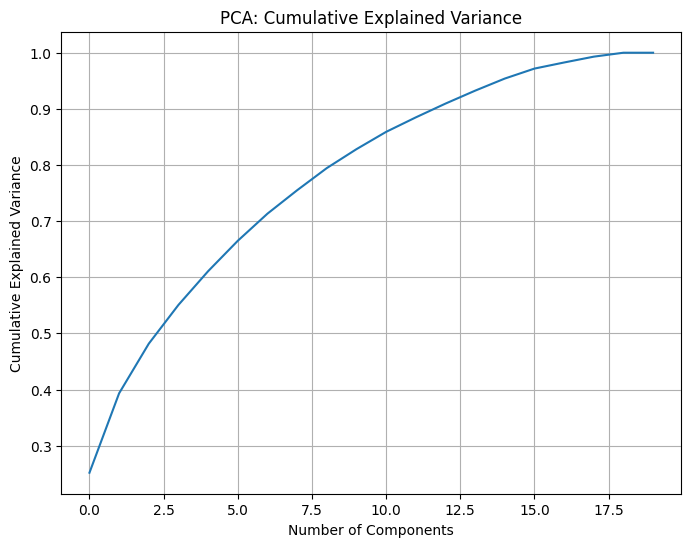

Number of components required to explain 90% of the variance: 13


In [7]:
# PCA for dimensionality reduction
pca = PCA()  # Initialize PCA without specifying n_components
pca.fit(cnn_features_scaled)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid()
plt.show()

# Determine the number of components required to explain 90% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.90) + 1  # Add 1 because index is zero-based

print(f"Number of components required to explain 90% of the variance: {num_components}")

In [8]:
# Apply PCA with the determined number of components
pca = PCA(n_components=num_components)
cnn_features_reduced = pca.fit_transform(cnn_features_scaled)


In [9]:
# Define binary labels for faces vs. vehicles
binary_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,1 ,1])  # 0 for faces, 1 for vehicles

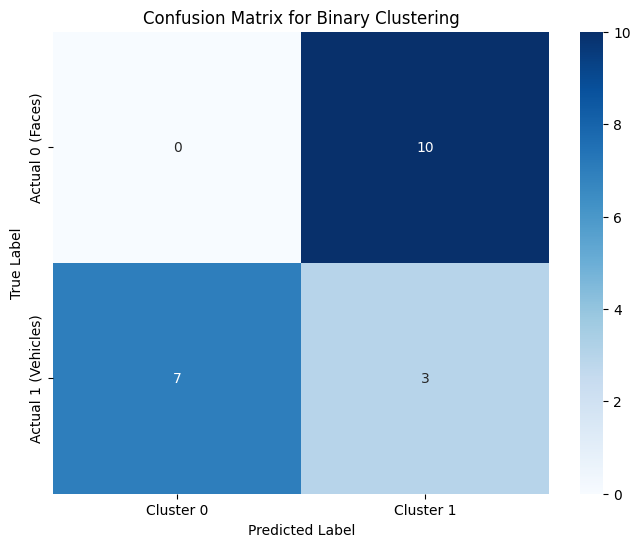

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Perform binary clustering using KMeans
kmeans_binary = KMeans(n_clusters=2, random_state=0, n_init=10)
binary_labels_pred = kmeans_binary.fit_predict(cnn_features_reduced)

# Compute the confusion matrix
conf_matrix = confusion_matrix(binary_labels, binary_labels_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=['Actual 0 (Faces)', 'Actual 1 (Vehicles)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Binary Clustering')
plt.show()

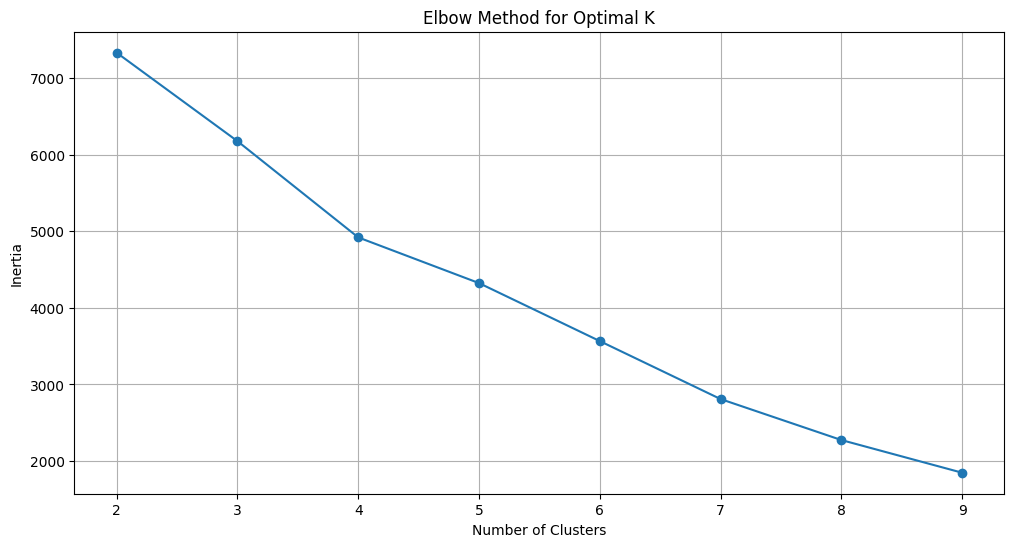

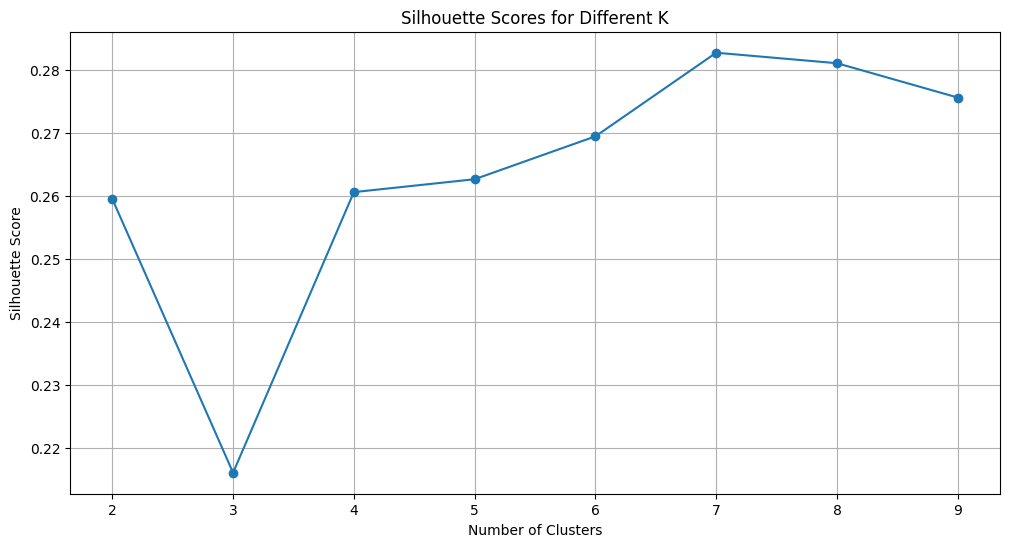

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Perform PCA with the desired number of components
pca = PCA(n_components=13)
cnn_features_reduced = pca.fit_transform(cnn_features_scaled)  # Assuming cnn_features_scaled is your standardized CNN features

# Determine the optimal number of clusters using the Elbow Method or Silhouette Score
inertia = []
sil_scores = []
n_clusters_range = range(2, 10)

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(cnn_features_reduced)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(cnn_features_reduced, kmeans.labels_))

# Plot the Elbow Method result
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Plot the Silhouette Score result
plt.figure(figsize=(12, 6))
plt.plot(n_clusters_range, sil_scores, marker='o')
plt.title('Silhouette Scores for Different K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


Silhouette Score for 4 clusters: 0.2606


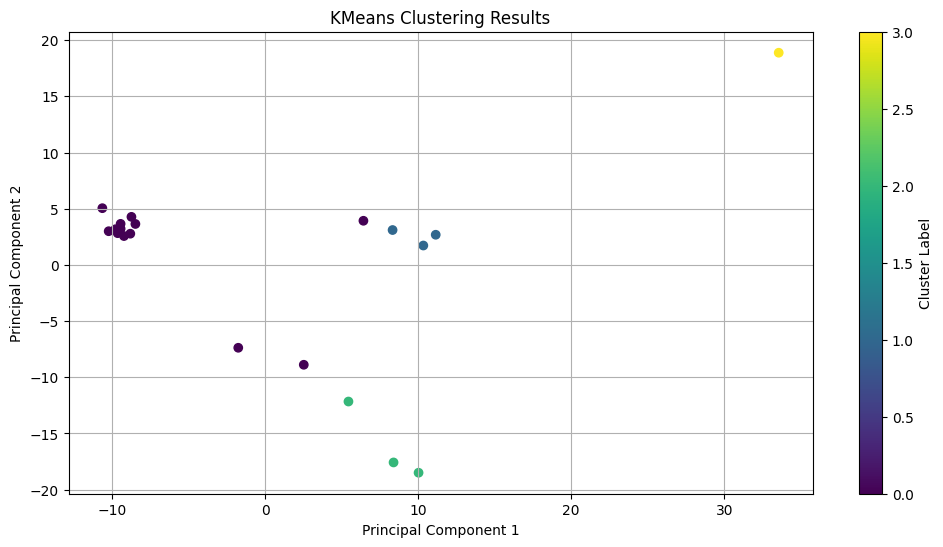

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming cnn_features_scaled is your standardized CNN features
# Perform PCA with the desired number of components
pca = PCA(n_components=13)
cnn_features_reduced = pca.fit_transform(cnn_features_scaled)

# Perform KMeans clustering with the optimal number of clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
cluster_labels = kmeans.fit_predict(cnn_features_reduced)

# Calculate the silhouette score
silhouette_avg = silhouette_score(cnn_features_reduced, cluster_labels)

print(f'Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}')

# Plot the clustering results
plt.figure(figsize=(12, 6))
plt.scatter(cnn_features_reduced[:, 0], cnn_features_reduced[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()
